# Part 1: KAN Implementation

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class LinearSpline(nn.Module):
    """
    A learnable piecewise linear activation function (linear spline).
    Knots are trainable and define the shape of the activation.
    """
    def __init__(self, num_knots=5, init_scale=0.1):
        super().__init__()
        self.num_knots = num_knots

        # Initialize knot positions (x) linearly spaced in [-1, 1]
        self.register_buffer("knot_x", torch.linspace(-1, 1, num_knots))

        # Initialize knot values (y) randomly
        self.knot_y = nn.Parameter(torch.randn(num_knots) * init_scale)

    def forward(self, x):
        """
        Compute piecewise linear interpolation between knots.
        Args:
            x: Input tensor (any shape)
        Returns:
            Output tensor (same shape as x)
        """
        # Rescale x to [-1, 1] for stability (optional)
        x = torch.tanh(x)  # Ensures x ∈ [-1, 1]

        # Find the segment each x belongs to
        segments = torch.searchsorted(self.knot_x, x) - 1
        segments = segments.clamp(0, self.num_knots - 2)

        # Get neighboring knots
        x0 = self.knot_x[segments]
        x1 = self.knot_x[segments + 1]
        y0 = self.knot_y[segments]
        y1 = self.knot_y[segments + 1]

        # Linear interpolation: y = y0 + (y1 - y0) * (x - x0) / (x1 - x0)
        alpha = (x - x0) / (x1 - x0 + 1e-6)
        return y0 + alpha * (y1 - y0)

class KANLayer(nn.Module):
    """
    A single KAN layer with learnable piecewise linear activations.
    Replaces a traditional linear layer.
    """
    def __init__(self, input_dim, output_dim, num_knots=5):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim

        # Each edge has its own spline activation
        self.splines = nn.ModuleList([
            LinearSpline(num_knots) for _ in range(input_dim * output_dim)
        ])

        # Optional: Add a small trainable bias
        self.bias = nn.Parameter(torch.zeros(output_dim))

    def forward(self, x):
        batch_size = x.shape[0]
        out = torch.zeros(batch_size, self.output_dim).to(x.device)

        # Apply each spline to its corresponding input
        for j in range(self.output_dim):
            for i in range(self.input_dim):
                spline_idx = i * self.output_dim + j
                out[:, j] += self.splines[spline_idx](x[:, i])

        return out + self.bias

class KAN(nn.Module):
    """
    A simple KAN with 2 layers (input -> hidden -> output).
    """
    def __init__(self, input_dim, hidden_dim, output_dim, num_knots=5):
        super().__init__()
        self.layer1 = KANLayer(input_dim, hidden_dim, num_knots)
        self.layer2 = KANLayer(hidden_dim, output_dim, num_knots)

    def forward(self, x):
        x = self.layer1(x)
        x = torch.relu(x)  # Optional: Add fixed nonlinearity between KAN layers
        x = self.layer2(x)
        return x


# Part 2: Training on Toy Dataset

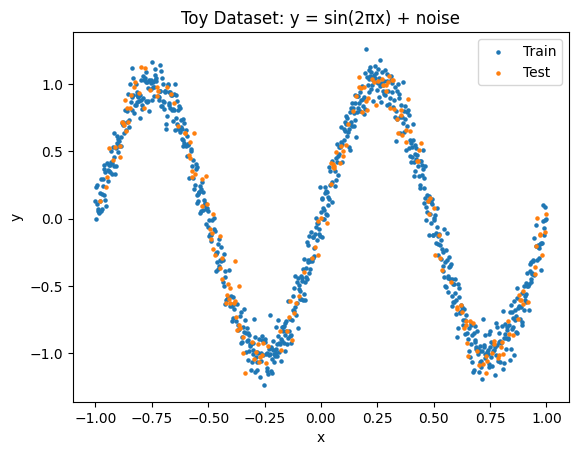

In [3]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Generate toy dataset: y = sin(2πx) + noise
def generate_data(n_samples=1000, noise=0.1):
    x = np.linspace(-1, 1, n_samples)
    y = np.sin(2 * np.pi * x) + noise * np.random.randn(n_samples)
    return torch.FloatTensor(x).unsqueeze(1), torch.FloatTensor(y).unsqueeze(1)

x, y = generate_data()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Plot the dataset
plt.scatter(x_train, y_train, s=5, label="Train")
plt.scatter(x_test, y_test, s=5, label="Test")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Toy Dataset: y = sin(2πx) + noise")
plt.legend()
plt.show()

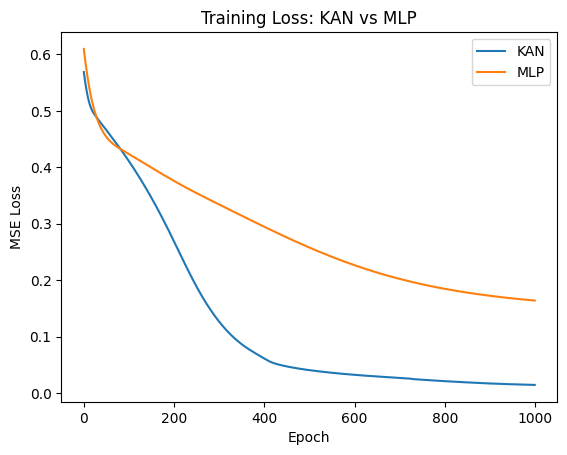

In [7]:
# Initialize models
kan = KAN(input_dim=1, hidden_dim=10, output_dim=1, num_knots=5)
mlp = nn.Sequential(
    nn.Linear(1, 32), nn.ReLU(),
    nn.Linear(32, 1)
)

# Training loop
def train(model, x_train, y_train, epochs=1000, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    losses = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        y_pred = model(x_train)
        loss = nn.MSELoss()(y_pred, y_train)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return losses

# Train both models
kan_losses = train(kan, x_train, y_train)
mlp_losses = train(mlp, x_train, y_train)

# Plot training losses
plt.plot(kan_losses, label="KAN")
plt.plot(mlp_losses, label="MLP")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training Loss: KAN vs MLP")
plt.legend()
plt.show()

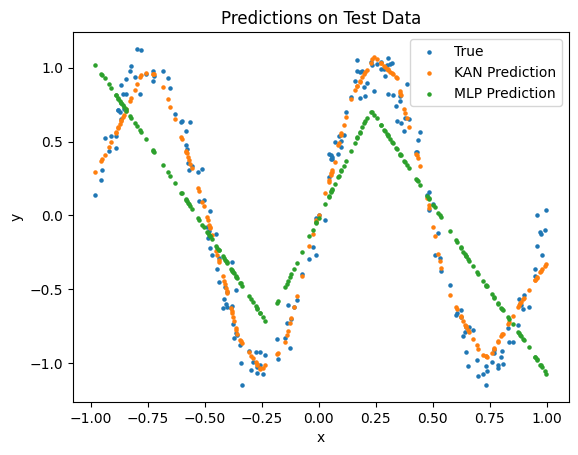

In [8]:
# Predictions
with torch.no_grad():
    kan_pred = kan(x_test)
    mlp_pred = mlp(x_test)

# Plot results
plt.scatter(x_test, y_test, s=5, label="True")
plt.scatter(x_test, kan_pred, s=5, label="KAN Prediction")
plt.scatter(x_test, mlp_pred, s=5, label="MLP Prediction")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Predictions on Test Data")
plt.legend()
plt.show()

# Part 3: Analysis